### This is a notebook to format your data for segmentation, run the images through the cloud instance of Mesmer, and then extract marker counts and morphological information from all the cells in your images

In [33]:
# import required packages
import os
import warnings
import skimage.io as io
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np

from ark.utils import data_utils, deepcell_service_utils, io_utils, load_utils, io_utils, plot_utils, segmentation_utils
from ark.segmentation import marker_quantification

### All data, images, files, etc. must be placed in the 'data' directory, and referenced via '../data/path_to_your_data'

If you're interested in directly interfacing with Google Drive, consult the documentation [here](https://ark-analysis.readthedocs.io/en/latest/_rtd/google_docs_usage.html).

In [34]:
# set up file paths
base_dir = "../data/IPIGYN043T1_8plex//"
input_dir = os.path.join(base_dir, "input_data")
tiff_dir = os.path.join(input_dir, "single_channel_inputs/")
deepcell_input_dir = os.path.join(input_dir, "deepcell_input/")
deepcell_output_dir = os.path.join(base_dir, 'deepcell_output')
single_cell_dir = os.path.join(base_dir, "single_cell_output")
viz_dir = os.path.join(base_dir, "deepcell_visualization")

In [3]:
# create directories if do not exist
for directory in [deepcell_input_dir, deepcell_output_dir, single_cell_dir, viz_dir, tiff_dir]:
    if not os.path.exists(directory):
        os.makedirs(directory)

### Here we are using the example data located in /data/example_dataset/input_data. To modify this notebook to run using your own data, simply change the base_dir to point to your own sub-directory within the data folder, rather than 'example_dataset'. 

In [4]:
# validate paths
io_utils.validate_paths([base_dir,
                         input_dir,
                         tiff_dir,
                         deepcell_input_dir,
                         deepcell_output_dir,
                         single_cell_dir,
                         viz_dir
                         ])

### compute and filter fov paths

In [35]:
# set this to true for multi-channel tiffs
MIBItiff = False

# data file suffix for low-level processed data
# only needed for MIBItiff = True
MIBItiff_suffix = "-MassCorrected-Filtered.tiff"

In [36]:
# either get all fovs in the folder...
if MIBItiff:
    fovs = io_utils.list_files(tiff_dir, substrs=MIBItiff_suffix)
else:
    fovs = io_utils.list_folders(tiff_dir)

# ... or optionally, select a specific set of fovs manually
# fovs = ["fov1", "fov2"]

# TODO: MIBItiff manual selection

### load images into notebook, process, and save as Mesmer compatable input

In [37]:
# NOTE: at least one of nucs and mems must not be None
# nuclear channel name(s) (or nucs = None)
nucs = ['DAPI']

# membrane channel name(s) (or mems = None)
mems = ['CD8','CD4','CD163','CD3']

In [8]:
# generate and save deepcell input tifs
data_utils.generate_deepcell_input(
    deepcell_input_dir, tiff_dir, nucs, mems, fovs,
    is_mibitiff=False, img_sub_folder="TIFs", batch_size=5
)

/usr/local/lib/python3.6/site-packages/ark/utils/load_utils.py:165: UserWarning: The supplied non-float dtype int16 was overwritten to float64, because the loaded images are floats
  warnings.warn(f"The supplied non-float dtype {dtype} was overwritten to {data_dtype}, "


## Upload files to Deepcell and download results

Deepcell input images will be zipped into a single file, uploaded to [deepcell.org](https://deepcell.org),

and the output will be downloaded to the deepcell output directory.

In [9]:
# Mesmer was trained on data acquired at 20X resolution. If your image data was acquired at a different resolution, you will get the best performance by rescaling. The rescale factor will increase or decrease the image resolution by the value you provide. For example, if you data was acquired at 10X, use a `rescale_factor` of 2. If your data was acquired at 60X resolution, use a `rescale_factor` of 0.33.
rescale_factor = 1.0

In [10]:
deepcell_service_utils.create_deepcell_output(deepcell_input_dir, deepcell_output_dir, fovs=fovs, scale=rescale_factor)

Processing tiffs in 1 batches...
Zipping preprocessed tif files.


/usr/local/lib/python3.6/site-packages/ark/utils/deepcell_service_utils.py:101: UserWarning: ../data/IPIKID090T1_8plex//input_data/deepcell_input/fovs_batch_1.zip will be overwritten
  warnings.warn(f'{zip_path} will be overwritten')


Uploading files to DeepCell server.
Segmentation progress:


  0%|          | 0/100 [00:00<?]

Extracting tif files from DeepCell response.


### We can then save the segmented mask overlaid on the imaging data

fov39


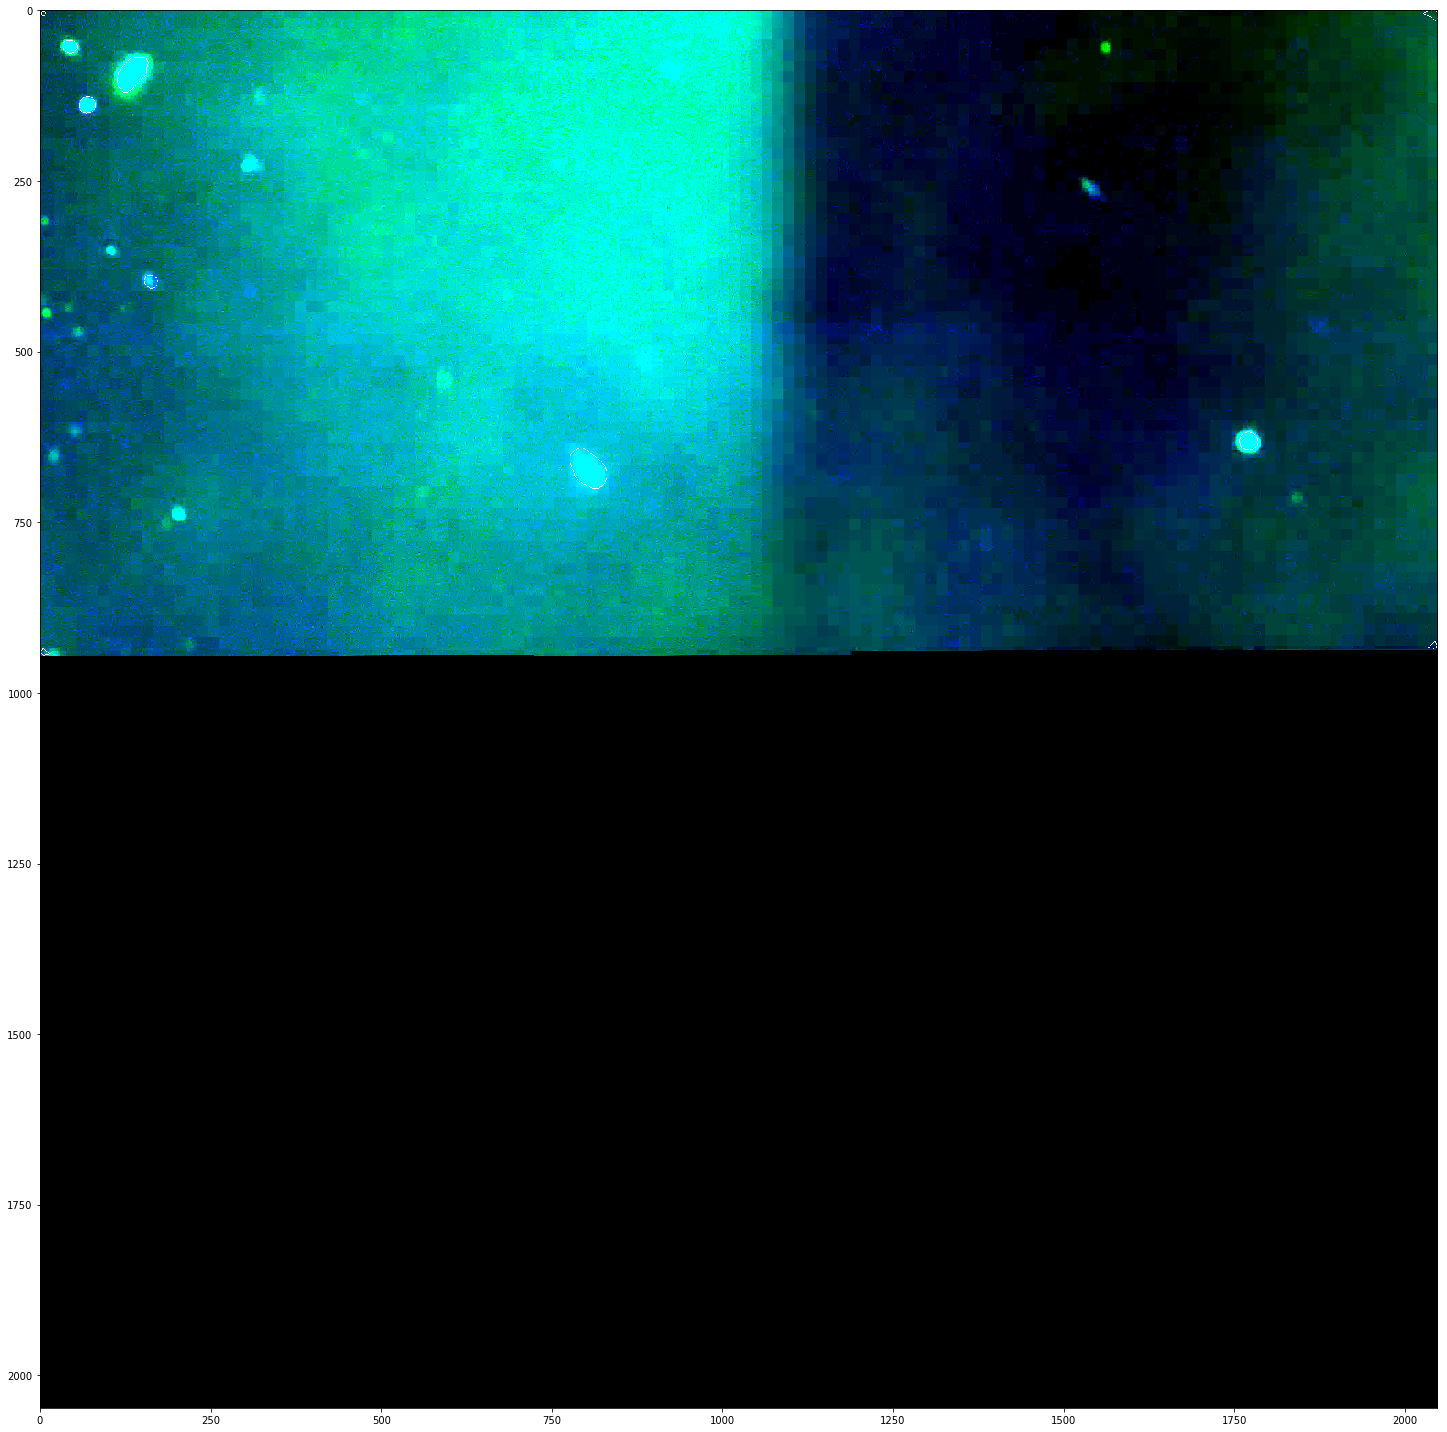

In [11]:
# display the channel overlay for a fov, useful for quick verification
warnings.simplefilter("ignore")

fov = 3

fov_to_display = io_utils.remove_file_extensions([fovs[fov]])[0]

fov_overlay = plot_utils.create_overlay(
    fov=fov_to_display,
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    img_overlay_chans=['nuclear_channel', 'membrane_channel'],
    seg_overlay_comp='whole_cell'
)

plt.figure(figsize=(20,20))

io.imshow(fov_overlay)
print(fovs[fov])
plt.savefig(viz_dir + "/example_deepcell_output_" + fovs[fov] + ".tiff")

In [12]:
# save the overlaid segmentation labels for each fov (these will not display, but will save in viz_dir)
segmentation_utils.save_segmentation_labels(
    segmentation_dir=deepcell_output_dir,
    data_dir=deepcell_input_dir,
    output_dir=viz_dir,
    fovs=io_utils.remove_file_extensions(fovs)
)

### Afterwards, we can generate expression matrices from the labeling + imaging data

In [13]:
# set to True to add nuclear cell properties to the expression matrix
nuclear_counts = True

In [38]:
labels = load_utils.load_imgs_from_dir(data_dir=deepcell_output_dir,
                                               files=[fov + '_feature_0.tif' for fov in fovs],
                                               xr_dim_name='compartments',
                                               xr_channel_names=['whole_cell'],
                                               trim_suffix='_feature_0',
                                               match_substring='_feature_0',
                                               force_ints=True)
labels.to_netcdf(os.path.join(single_cell_dir, "segmentation_labels.nc"))
# generates segmentation borders and labels
#labels = labels.loc[fov, :, :, 'whole_cell'].values

In [2]:
labels

NameError: name 'labels' is not defined

For a full list of features extracted, please refer to the cell table section of: https://ark-analysis.readthedocs.io/en/latest/_rtd/data_types.html

In [14]:
# now extract the segmented imaging data to create normalized and transformed expression matrices
# note that if you're loading your own dataset, please make sure all the imaging data is in the same folder
# with each fov given its own folder and all fovs having the same channels
cell_table_size_normalized, cell_table_arcsinh_transformed = \
    marker_quantification.generate_cell_table(segmentation_dir=deepcell_output_dir,
                                              tiff_dir=tiff_dir,
                                              img_sub_folder="TIFs",
                                              is_mibitiff=MIBItiff,
                                              fovs=fovs,
                                              batch_size=5,
                                              nuclear_counts=nuclear_counts)

extracting data from fov0
extracting data from fov1
extracting data from fov10
extracting data from fov11
extracting data from fov12
extracting data from fov13
extracting data from fov14
extracting data from fov15
extracting data from fov16
extracting data from fov17
extracting data from fov18
extracting data from fov19
extracting data from fov2
extracting data from fov20
extracting data from fov21
extracting data from fov22
extracting data from fov23
extracting data from fov24
extracting data from fov25
extracting data from fov26
extracting data from fov27
extracting data from fov28
extracting data from fov29
extracting data from fov3
extracting data from fov30
extracting data from fov31
extracting data from fov32
extracting data from fov33
extracting data from fov34
extracting data from fov35
extracting data from fov36
extracting data from fov37
extracting data from fov38
extracting data from fov39
extracting data from fov4
extracting data from fov40
extracting data from fov41
extrac

In [15]:
# save extracted data as csv for downstream analysis
cell_table_size_normalized.to_csv(os.path.join(single_cell_dir, 'cell_table_size_normalized.csv'),
                                 index=False)
cell_table_arcsinh_transformed.to_csv(os.path.join(single_cell_dir, 'cell_table_arcsinh_transformed.csv'),
                                     index=False)